<a href="https://colab.research.google.com/github/rishi0129/865-Project/blob/main/865Project_Rishikesh_Vipul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimal solution is: $__not_solved__ after 0.218 milliseconds.
Optimal solution is: $__not_solved__ after 0.332 milliseconds.
Optimal solution is: $__not_solved__ after 0.474 milliseconds.
Optimal solution is: $__not_solved__ after 0.607 milliseconds.
Optimal solution is: $__not_solved__ after 0.743 milliseconds.
Optimal solution is: $12668.872281772557 after 0.982 milliseconds.
Optimal solution is: $12668.872281772557 after 1.265 milliseconds.
Optimal solution is: $12668.872281772557 after 1.617 milliseconds.
Optimal solution is: $12668.872281772557 after 2.019 milliseconds.
Optimal solution is: $12668.872281772557 after 2.499 milliseconds.
Optimal solution is: $12668.872281772557 after 2.945 milliseconds.
Optimal solution is: $12668.872281772557 after 3.448 milliseconds.
Optimal solution is: $12668.872281772557 after 3.98 milliseconds.
Optimal solution is: $12668.872281772557 after 4.633 milliseconds.
Optimal solution is: $12668.872281772557 after 5.258 milliseconds.
Optimal solution

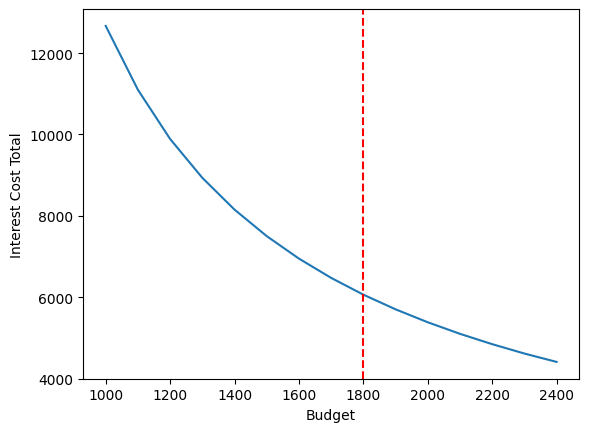

       0        1        2        3        4        5        6        7    \
0    86.12    86.12    86.12    86.12    86.12    86.12    86.12    86.12   
1  1422.56  1422.56  1422.56  1422.56  1422.56  1422.56  1422.56  1422.56   
2   186.60   186.60   186.60   186.60   186.60   186.60   186.60   186.60   
3   204.72   204.72   204.72   204.72   204.72   204.72   204.72   204.72   

           8        9    ...  110  111  112  113  114  115  116  117  118  119  
0    86.120000    86.12  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    81.257627     0.00  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2   186.600000   186.60  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  1546.022373  1627.28  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[4 rows x 120 columns]


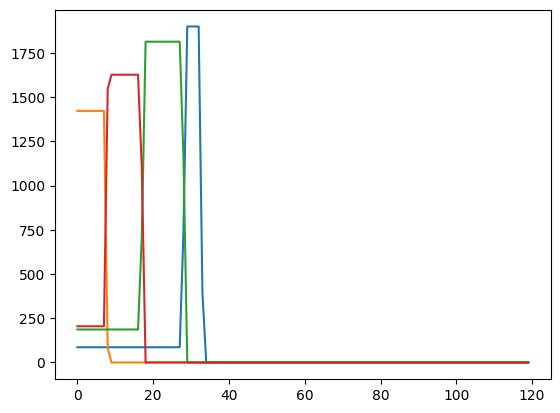

In [13]:
# Import libraries
import numpy as np
from ortools.linear_solver import pywraplp

# Main function
def opt_pay_schedule(
    term_months=[80, 120, 100],  # loan term in months
    principal_initial=[9871.59, 11040.71, 20879.70],  # starting principal at time 0
    rate_yearly=[0.0531, 0.0631, 0.0584],  # yearly interest rate
    decision_min=[86.12, 70.54, 186.60],  # minimum payment per term
    budget=1800,  # maximum possible payment
    verbose=[True, 50]  # If verbose is true, query solver for intermediate results for given time interval
):

    # Declare variables
    rate_monthly = np.array(rate_yearly) / 12
    num_loans = len(principal_initial)
    max_term_months = max(term_months)

    # Declare solver
    solver = pywraplp.Solver("payoff", pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # If verbose is true, query solver for intermediate results
    if verbose[0] == True:
        time_limit_milliseconds = verbose[1]
        solver.set_time_limit(time_limit_milliseconds)

    # Declare solver variables
    # Payment is the decision variable
    decision = np.array([
        [solver.NumVar(0, budget, 'd_i' + str(i) + '_t_' + str(t))
         for t in range(max_term_months)]
        for i in range(num_loans)
    ])

    # Principal
    principal = np.array([
        [solver.NumVar(0, solver.infinity(), 'p_i' + str(i) + '_t_' + str(t))
         for t in range(max_term_months)]
        for i in range(num_loans)
    ])

    # Binary for whether loan is principal remains(1) or not(0), i.e. is loan paid off
    remnant = np.array([
        [solver.BoolVar('b_i' + str(i) + '_t_' + str(t))
         for t in range(max_term_months)]
        for i in range(num_loans)
    ])

    # Declare minimization objective
    solver.Minimize(
        sum(sum(decision[i, :]) + sum(remnant[i, :]) for i in range(num_loans))
    )

    # Set constraints
    # Starting principal is nonzero
    constraint_principal_init = [solver.Constraint(principal_initial[i], principal_initial[i]) for i in range(num_loans)]
    for i in range(num_loans):
        constraint_principal_init[i].SetCoefficient(principal[i, 0], 1)

    # Principal is zero at end of term
    constraint_payoff_tmax = np.array([solver.Add(principal[i, term_months[i] - 1] <= 0) for i in range(num_loans)])

    # Principal in each period is equal to principal of previous period, interest, and payment
    constraint_principal_rolling = np.array([
        [solver.Add((principal[i, t] == (1 + rate_monthly[i]) * principal[i, t - 1] - decision[i, t - 1]))
         for t in range(1, max_term_months)]
        for i in range(num_loans)
    ])

    # Sum of payments must not exceed budget
    constraint_budget = np.array([
        solver.Add(sum(decision[i, t] for i in range(num_loans)) <= budget)
        for t in range(max_term_months)
    ])

    # Remnant
    constraint_remnant = np.array([
        [solver.Add(remnant[i, t] >= principal[i,t]/principal_initial[i])
         for t in range(max_term_months)]
        for i in range(num_loans)
    ])

    # Monthly payment must meet minimum
    constraint_min_payment = np.array([
        [solver.Add(decision[i,t] >= decision_min[i]*remnant[i,t])
         for t in range(max_term_months)]
        for i in range(num_loans)
    ])

    # Solve
    if verbose[0] == True:
        status = solver.NOT_SOLVED  # set status flag to not solved
        i = 1  # set index flag
        while status != solver.OPTIMAL:
            status = solver.Solve()  # query solver status
            wall_time = solver.wall_time()  # query number of simplex iterations
            if status in (solver.FEASIBLE, solver.OPTIMAL):
                interest_cost = solver.Objective().Value() - sum(principal_initial) - sum(
                    [remnant[i, t].solution_value()
                     for i in range(num_loans)
                     for t in range(term_months[i])]
                )  # interest cost w/ optimal schedule
            else:
                interest_cost = "__not_solved__"
            print("Optimal solution is: $" + str(interest_cost) +
                  " after " + str(wall_time / 1000) + " milliseconds.")
            i = i + 1  # update flag
            solver.set_time_limit(time_limit_milliseconds * i)  # update time limit
    else:
        status = solver.Solve()

    decision_solution = np.array([
        [decision[i, t].solution_value() for t in range(max_term_months)]
        for i in range(num_loans)
    ])

    principal_solution = np.array([
        [principal[i, t].solution_value() for t in range(max_term_months)]
        for i in range(num_loans)
    ])

    interest_cost = solver.Objective().Value() - sum(principal_initial) - sum(
        [remnant[i, t].solution_value()
         for i in range(num_loans)
         for t in range(term_months[i])]
    )  # interest cost w/ optimal schedule

    print("Optimal payoff interest cost = " + str(interest_cost))

    # Return
    return [interest_cost, decision_solution]

# Generate solutions
start_budget = 1000
end_budget = 2500
interest_cost = []
payment_schedule = []
for budget_rate in range(start_budget, end_budget, 100):
    _solution = \
        opt_pay_schedule(
            term_months=[60, 120, 100, 100],
            principal_initial=[9871.59, 11040.71, 20879.70, 15600.74],
            rate_yearly=[0.0531, 0.10, 0.0584, 0.10],
            decision_min=[86.12, 70.54, 186.60, 204.72],
            budget=budget_rate)
    interest_cost.append(_solution[0])
    payment_schedule.append(_solution[1])
    del(_solution)

# Plot budget vs total cost of interest
plt.plot(list(range(start_budget, end_budget, 100)), interest_cost)
plt.axvline(1800, color='r', linestyle='dashed')
plt.xlabel('Budget')
plt.ylabel('Interest Cost Total')
plt.show()

import pandas as pd
import itertools
# Print payment schedule for $1800 budget
paysched = pd.DataFrame(__ for __ in itertools.zip_longest(*payment_schedule[9])).transpose()
print(paysched)

# Plot payment schedule for $1800 budget
plt.plot(np.transpose(np.array(paysched)))
plt.show()